# Описание

В этом ноутбуке будет проанализирован набор данных о голосовании на платформе Kaggle за 2021 год. Потенциально из этих данных можно извлечь некоторую полезную информацию о тенденциях и положении Data Science в последнее время, а также об участниках Kaggle. Посмотрим, что интересного получится узнать.

# Просмотр данных и импорт библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,8)
import re

In [5]:
df = pd.read_csv('kaggle_survey_2021_responses.csv')
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor..."
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [6]:
mv_cols = df.isnull().sum()/len(df) # Пропущенные значения в столбцах

In [7]:
# Вопросы сохранены в отдельную переменную

questions = df.iloc[0]
top_questions = questions[mv_cols[mv_cols<0.8].index]

df = df[df['Q2'].isin(['Man', 'Woman'])] # Датафрейм с данными только о тех, кто явно указал пол

In [8]:
tq_df = df[mv_cols[mv_cols<0.8].index] # Датафрейм, в котором содержатся вопросы с 20 и более % ответов

In [9]:
df.shape

(25488, 369)

# Пропущенные значения

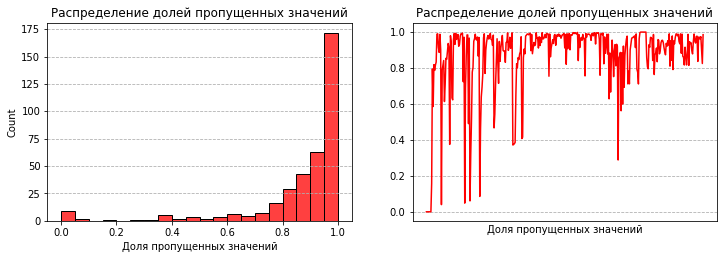

In [10]:
plt.subplot(221)
sns.histplot(mv_cols, bins=np.arange(0, 1.05, 0.05), color='r')
plt.grid(True, axis='y', ls='dashed')
plt.title('Распределение долей пропущенных значений')
plt.xlabel('Доля пропущенных значений');

plt.subplot(222)
plt.plot(mv_cols, color='r')
plt.grid(True, axis='y', ls='dashed')
plt.title('Распределение долей пропущенных значений')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.xlabel('Доля пропущенных значений');

Видно, что большая часть вопросов осталась практически без ответов. В начале пропущенных вопросов меньше, чем в конце.

# Количество ответов

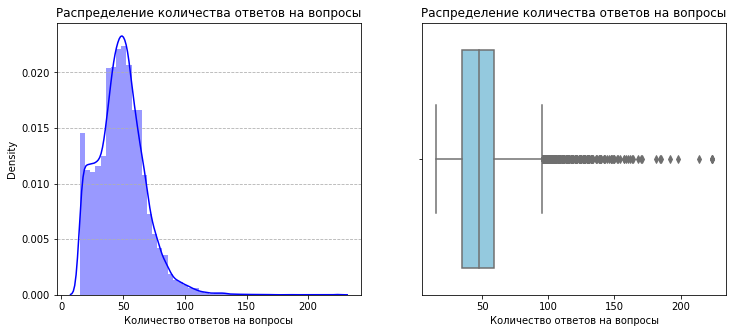

In [11]:
answers_count = df.shape[1] - df.isnull().sum(axis=1) # Кол-во вопросов, на которые ответил каждый участник

plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.distplot(answers_count, color='b')
plt.grid(True, axis='y', ls='dashed')
plt.title('Распределение количества ответов на вопросы')
plt.xlabel('Количество ответов на вопросы');

plt.subplot(122)
sns.boxplot(answers_count, color='skyblue')
plt.title('Распределение количества ответов на вопросы')
plt.xlabel('Количество ответов на вопросы');

In [12]:
answers_count.describe()

count    25488.000000
mean        48.354324
std         19.407128
min         15.000000
25%         35.000000
50%         48.000000
75%         59.000000
max        224.000000
dtype: float64

Количество ответов на вопросы распределено от 15 до 95, остальное можно считать выбросами. Мало кто отвечает на большее кол-во вопросов. Медиана - 48 ответов. Это лишь 13% ответов из всех возможных. 

In [13]:
df['Answers_count'] = answers_count 

In [14]:
answers_country = df.groupby('Q3').sum()['Answers_count'].sort_values(ascending=False).to_frame()

In [15]:
country_sex = df.groupby(['Q2','Q3'], as_index=False).size()

In [16]:
country_sex = pd.concat([country_sex[:66][['Q3', 'size']].rename(columns={'size':'man'}),
           country_sex[66:][['size']].rename(columns={'size':'woman'})
           .reset_index()], axis=1) \
            .drop(columns='index', axis=1) \
            .set_index('Q3')

In [17]:
man_vs_woman = country_sex['man']/country_sex['woman']

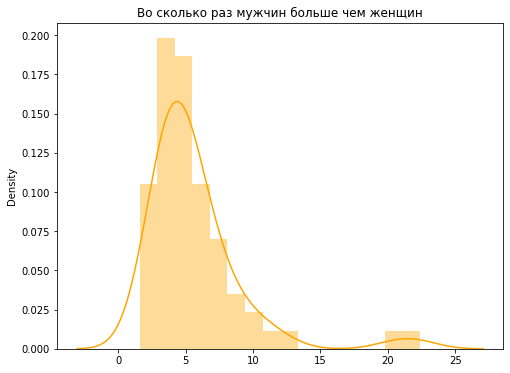

In [18]:
plt.figure(figsize=(8,6))
sns.distplot(man_vs_woman, color='orange')
plt.title('Во сколько раз мужчин больше чем женщин');

In [19]:
man_vs_woman.describe()

count    66.000000
mean      5.634011
std       3.592967
min       1.595238
25%       3.637041
50%       4.693673
75%       6.336112
max      22.400000
dtype: float64

Легко заметить, что мужчин, участвовавших в опросе, в разы больше, чем женщин. Если быть точнее, то медиана составляет 4,7 раз. Похоже, data science в основном интересна мужчинам, если судить по данным.

In [20]:
answers_country

,Answers_count
Q3,
India,346744
United States of America,129101
Other,60112
Japan,40058
Brazil,38677
...,...
Norway,2111
Iraq,2071
Algeria,2007


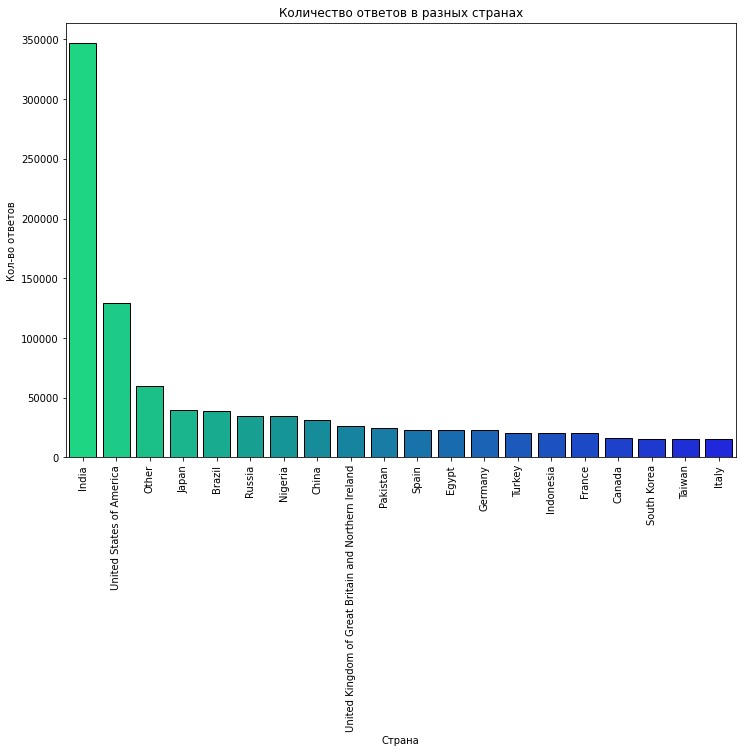

In [21]:
sns.barplot(data=answers_country[:20], x=answers_country[:20].index, y='Answers_count', palette='winter_r', ec='k')
plt.title('Количество ответов в разных странах')
plt.xticks(rotation=90)
plt.xlabel('Страна')
plt.ylabel('Кол-во ответов');

Наиболее активно отвечали участники опроса из Индии, США, Японии, Бразилии и России.

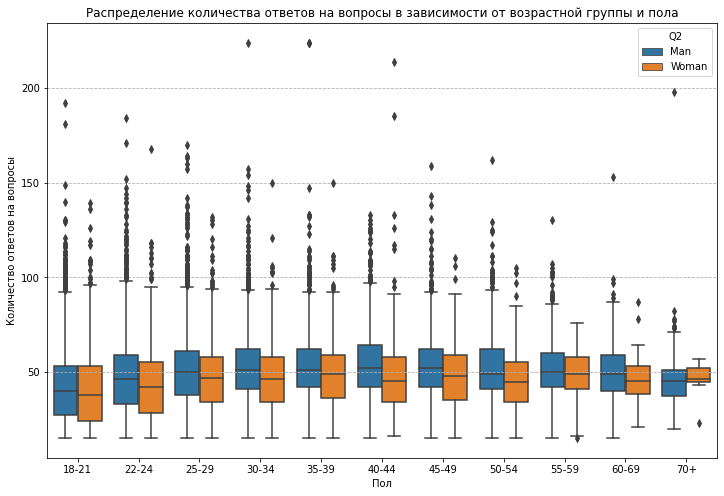

In [22]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.sort_values(by='Q1'), x='Q1', y='Answers_count', hue='Q2')
plt.grid(True, axis='y', ls='dashed')
plt.title('Распределение количества ответов на вопросы в зависимости от возрастной группы и пола')
plt.xlabel('Пол')
plt.ylabel('Количество ответов на вопросы');

Мужчины отвечают на большее количество вопросов по сравнению с женщинами. Люди среднего возраста зачастую отвечают на большее количество вопросов по сравнению с молодыми (до 25 лет).

# Время ответа

In [23]:
df.iloc[:, 0] = df.iloc[:, 0].astype('int')
time = df.iloc[:, 0]

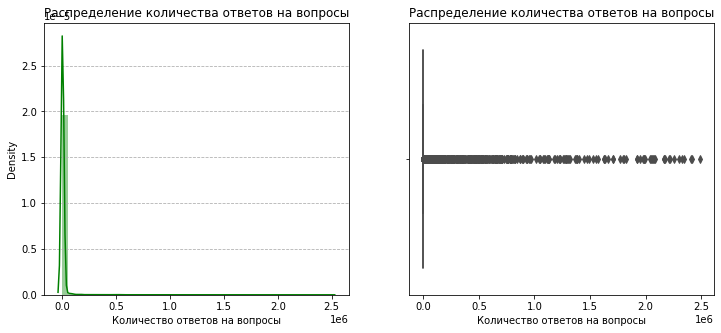

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.distplot(time, color='g')
plt.grid(True, axis='y', ls='dashed')
plt.title('Распределение количества ответов на вопросы')
plt.xlabel('Количество ответов на вопросы');

plt.subplot(122)
sns.boxplot(time, color='springgreen')
plt.title('Распределение количества ответов на вопросы')
plt.xlabel('Количество ответов на вопросы');

In [25]:
time.describe()

count    2.548800e+04
mean     1.105024e+04
std      1.019426e+05
min      1.200000e+02
25%      4.440000e+02
50%      6.560000e+02
75%      1.039000e+03
max      2.488653e+06
Name: Time from Start to Finish (seconds), dtype: float64

Распределение времени, затраченного на прохождение опроса, оказалось крайне неравномерным. Оно разнится от 2 минут до 4 недель. Медианой является 656 секунд, что примерно равно 11 минутам.

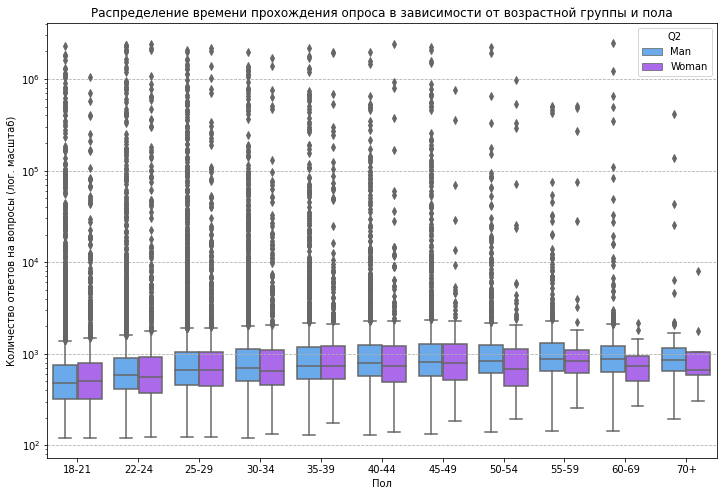

In [26]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.sort_values(by='Q1'), x='Q1', y=time, hue='Q2', palette='cool')
plt.grid(True, axis='y', ls='dashed')
plt.title('Распределение времени прохождения опроса в зависимости от возрастной группы и пола')
plt.xlabel('Пол')
plt.ylabel('Количество ответов на вопросы (лог. масштаб)')
plt.yscale('log');

На этом графике наблюдается похожая картина. Люди среднего возраста тратят больше времени на прохождение опроса, поскольку они отвечают на больше кол-во вопросов. Любопытно, но женщины тратят примерно такое же количество времени, что и мужчины, но при этом отвечают на меньшее количество вопросов. Возможно они более тщательно обдумывают вопросы.

# Вопросы

In [27]:
pd.set_option('display.max_colwidth', None)

In [28]:
top_questions_df = pd.concat([tq_df.nunique().
                              rename('unique_answers').to_frame(), top_questions.rename('question').to_frame()], axis=1)

In [29]:
top_questions_df = top_questions_df[(top_questions_df['unique_answers']>1) & (top_questions_df['unique_answers']<100)]

In [30]:
unique_answers = []
for col in top_questions_df.index:
    tq_df[col]
    s = list(df[col].unique())
    unique_answers.append(s)

In [31]:
top_questions_df['unique_answers'] = unique_answers

Ниже будет приведена статистика по наиболее популярным вопросам. Учитываются вопросы, на которые ответило не менее 20% участников (более 5097 человек).

## Возраст и пол

In [33]:
def group_size(question):
    data = df.groupby(question).size().sort_values(ascending=False)
    if 'None' in data.index:
        return data.drop('None', axis=0)
    if 'nan' in data.index:
        return data.drop('None', axis=0)
    else:
        return data

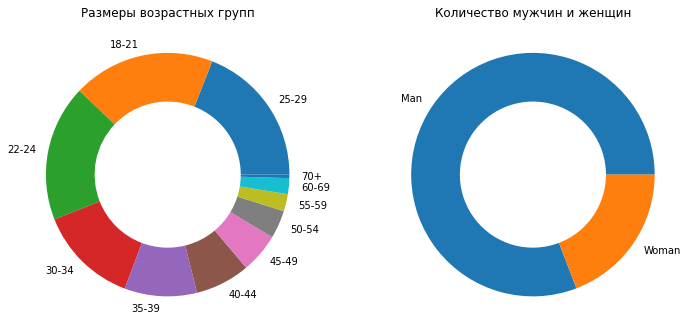

In [34]:
plt.subplot(121)
group_size('Q1').plot(kind='pie', wedgeprops = dict(width = 0.4))
plt.ylabel('')
plt.title('Размеры возрастных групп');

plt.subplot(122)
group_size('Q2').plot(kind='pie', wedgeprops = dict(width = 0.4))
plt.ylabel('')
plt.title('Количество мужчин и женщин');

Более половины опрошенных - молодые люди от 18 до 29 лет. Мужчин более 80%.

## Образование

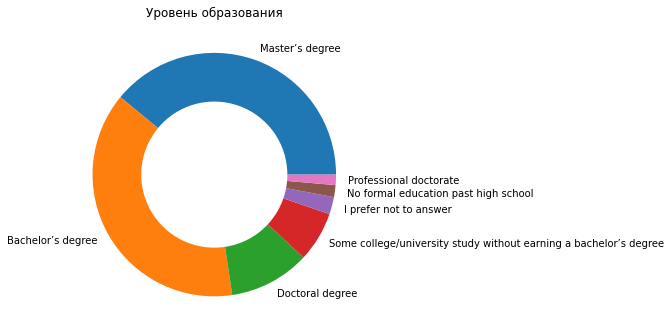

In [35]:
plt.subplot(121)
group_size('Q4').plot(kind='pie', wedgeprops = dict(width = 0.4))
plt.title('Уровень образования')
plt.ylabel('');

Две наиболее крупные категории - бакалавры и магистры. Получается, что в сфере data science очень высокий процент образованных людей, что на самом деле не удивительно.

## Специализация

In [36]:
def make_barplot(question, palette, orient, title):
    if orient=='v':
        plt.figure(figsize=(10,6))
        sns.barplot(data=group_size(question).to_frame(), x=group_size(question).index, y=group_size(question), 
                    ec='k', palette=palette, zorder=2, 
                    estimator=lambda x: sum(x)*100/group_size(question).sum())

        plt.xticks(rotation=90)
        plt.xlabel('')
        plt.ylabel('%')
        plt.grid(True, axis='y', ls='dashed')
        plt.title(title);
        
    if orient == 'h':
        plt.figure(figsize=(10,6))
        sns.barplot(data=group_size(question).to_frame(), y=group_size(question).index, x=group_size(question), 
            ec='k', palette=palette, zorder=2, estimator=lambda x: sum(x)*100/group_size(question).sum())
        plt.xlabel('%')
        plt.ylabel('')
        plt.grid(True, axis='y', ls='dashed')
        plt.title(title);

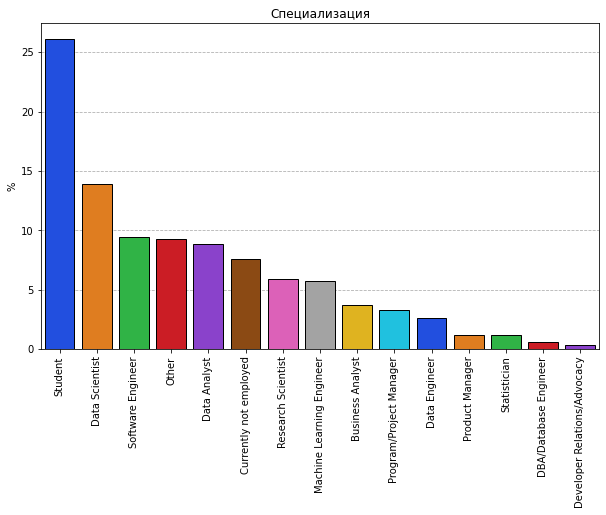

In [37]:
make_barplot('Q5', 'bright', 'v', 'Специализация')

Значительная часть опрошенных оказалась студентами. Из тех, кто имеет опыт работы, наиболее популярны профессии Data Scientist, Software Engineer (что слегка неожиданно), а также Data Analyst. Не стоит забывать, что Data Scientist это зачастую довольно растяжимое понятие, которое может в себя включать и другие специализации.

## Опыт в написании кода

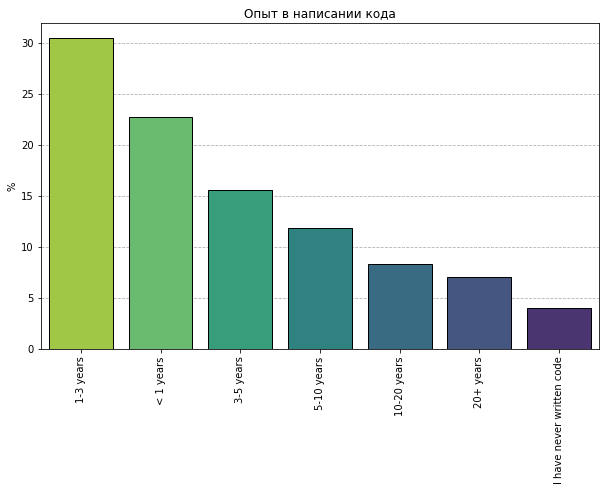

In [38]:
make_barplot('Q6', 'viridis_r', 'v', 'Опыт в написании кода')

Чуть более половины респондентов имеет опыт написания кода до 3 лет, но и профессиональных программистов тоже немало.

## Какой язык стоит учить начинающему Data Scientist'у?

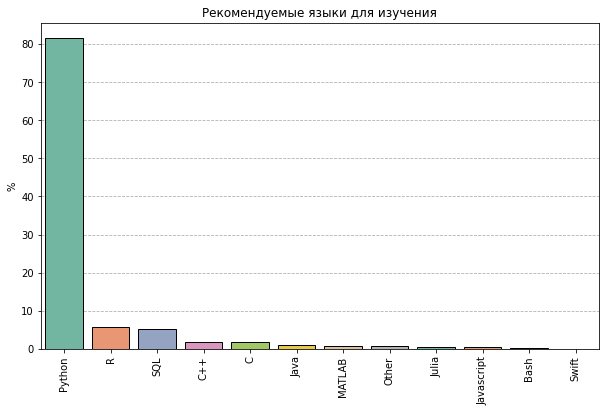

In [39]:
make_barplot('Q8', 'Set2', 'v', 'Рекомендуемые языки для изучения')

Как и следовало ожидать, python сейчас наиболее востребованный язык для Data Science. На втором и третьем месте с большим отставанием идут R и SQL.

## Наиболее популярные платформы для проектов

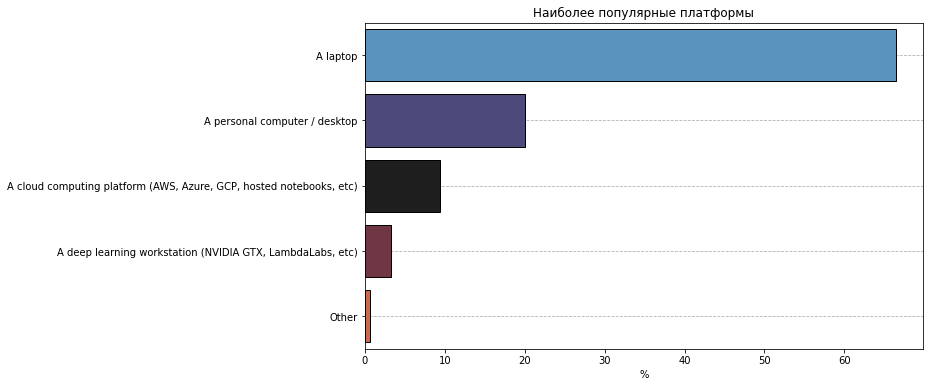

In [40]:
make_barplot('Q11', 'icefire', 'h', 'Наиболее популярные платформы')

Многие участники (более 60%) программируют на своем ноутбуке, реже - на компьютере, реже всего на облачных и специальных платформах.

## Использование TPU

Tensor processing unit (TPU) - микросхема от Google, созданная для улучшения обучения моделей МО и нейронных сетей.
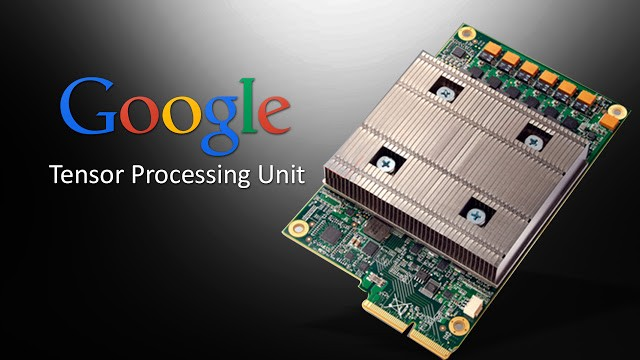

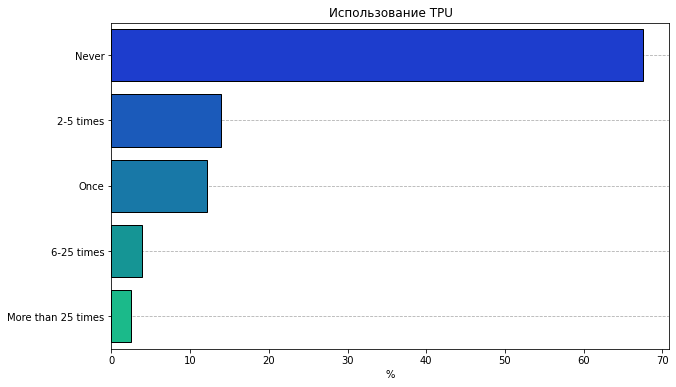

In [41]:
make_barplot('Q13', 'winter', 'h', 'Использование TPU')

Более 60% опрошенных никогда не использовали данную микросхему.

## Использование методов машинного обучения

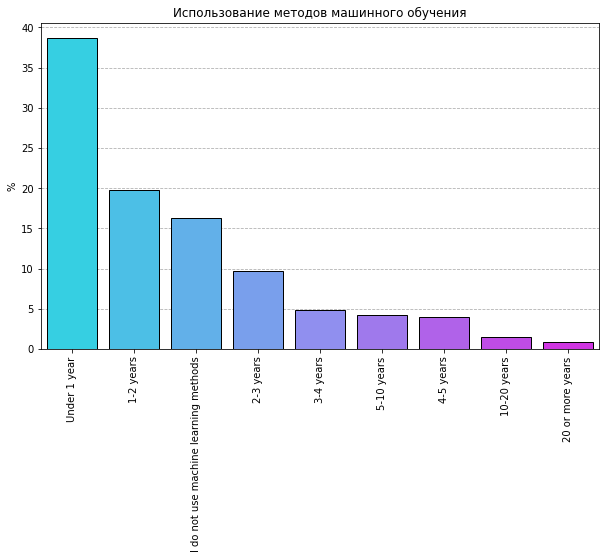

In [42]:
make_barplot('Q15', 'cool', 'v', 'Использование методов машинного обучения')

Многие респонденты используют методы МО не более 2 лет или же не используют вовсе.

## Отрасль

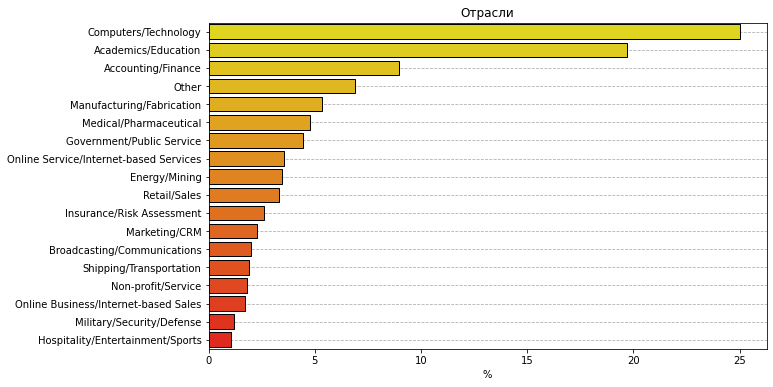

In [43]:
make_barplot('Q20', 'autumn_r', 'h', 'Отрасли')

Наиболее часто DS используется в информационной (компьютерной), образовательной и финансовой области.

## Размер компании

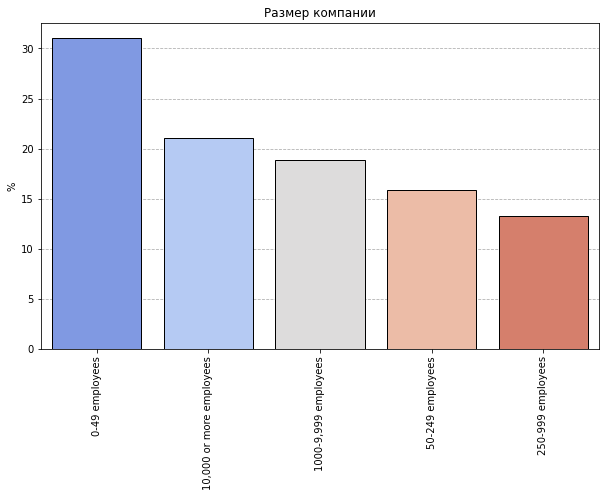

In [44]:
make_barplot('Q21', 'coolwarm', 'v', 'Размер компании')

Чаще всего опрошенные отвечали, что работают в небольших компаниях (штат до 50 человек). Немало и тех, кто работает в крупных компаниях.

## Внедрение методов МО в бизнес

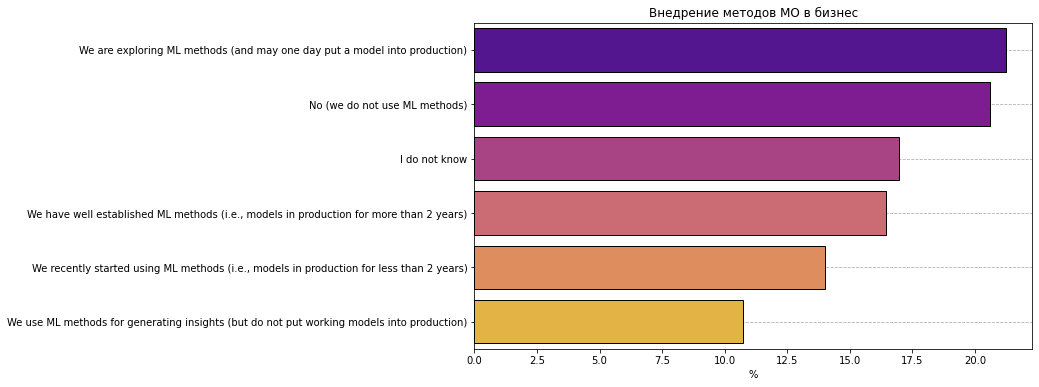

In [45]:
make_barplot('Q23', 'plasma', 'h', 'Внедрение методов МО в бизнес')

Более 40% работодателей активно используют методы машинного обучения в деятельности своих компаний.

## Годовая компенсация

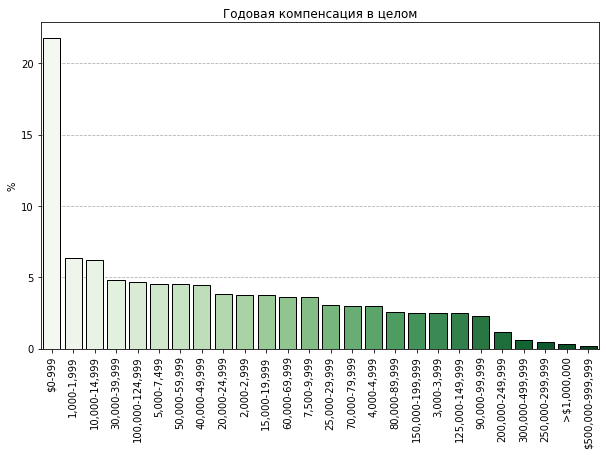

In [46]:
make_barplot('Q25', 'Greens', 'v', 'Годовая компенсация в целом')

Более 20% опрошенных получают годовую компенсацию менее 1000 долларов.

In [47]:
# Компенсация для разных стран

compensation = df.groupby(['Q3', 'Q25'], as_index=False).size()

In [49]:
# Преобразование столбца с компенсацией

compensation['Q25'] = compensation['Q25'].apply(lambda x: int(re.sub(',', '', 
                                                                     x.partition('-')[2]))+1 if '-' in x else 1000000)

In [89]:
def show_compensation_in_country(country):
    data=compensation[compensation['Q3']==country]
    sns.barplot(data=compensation[compensation['Q3']==country], x='Q25', y='size', ec='k', palette='vlag',
              estimator=lambda x: sum(x)*100/data['size'].sum())
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Годовая компенсация участников Kaggle в стране {country}');

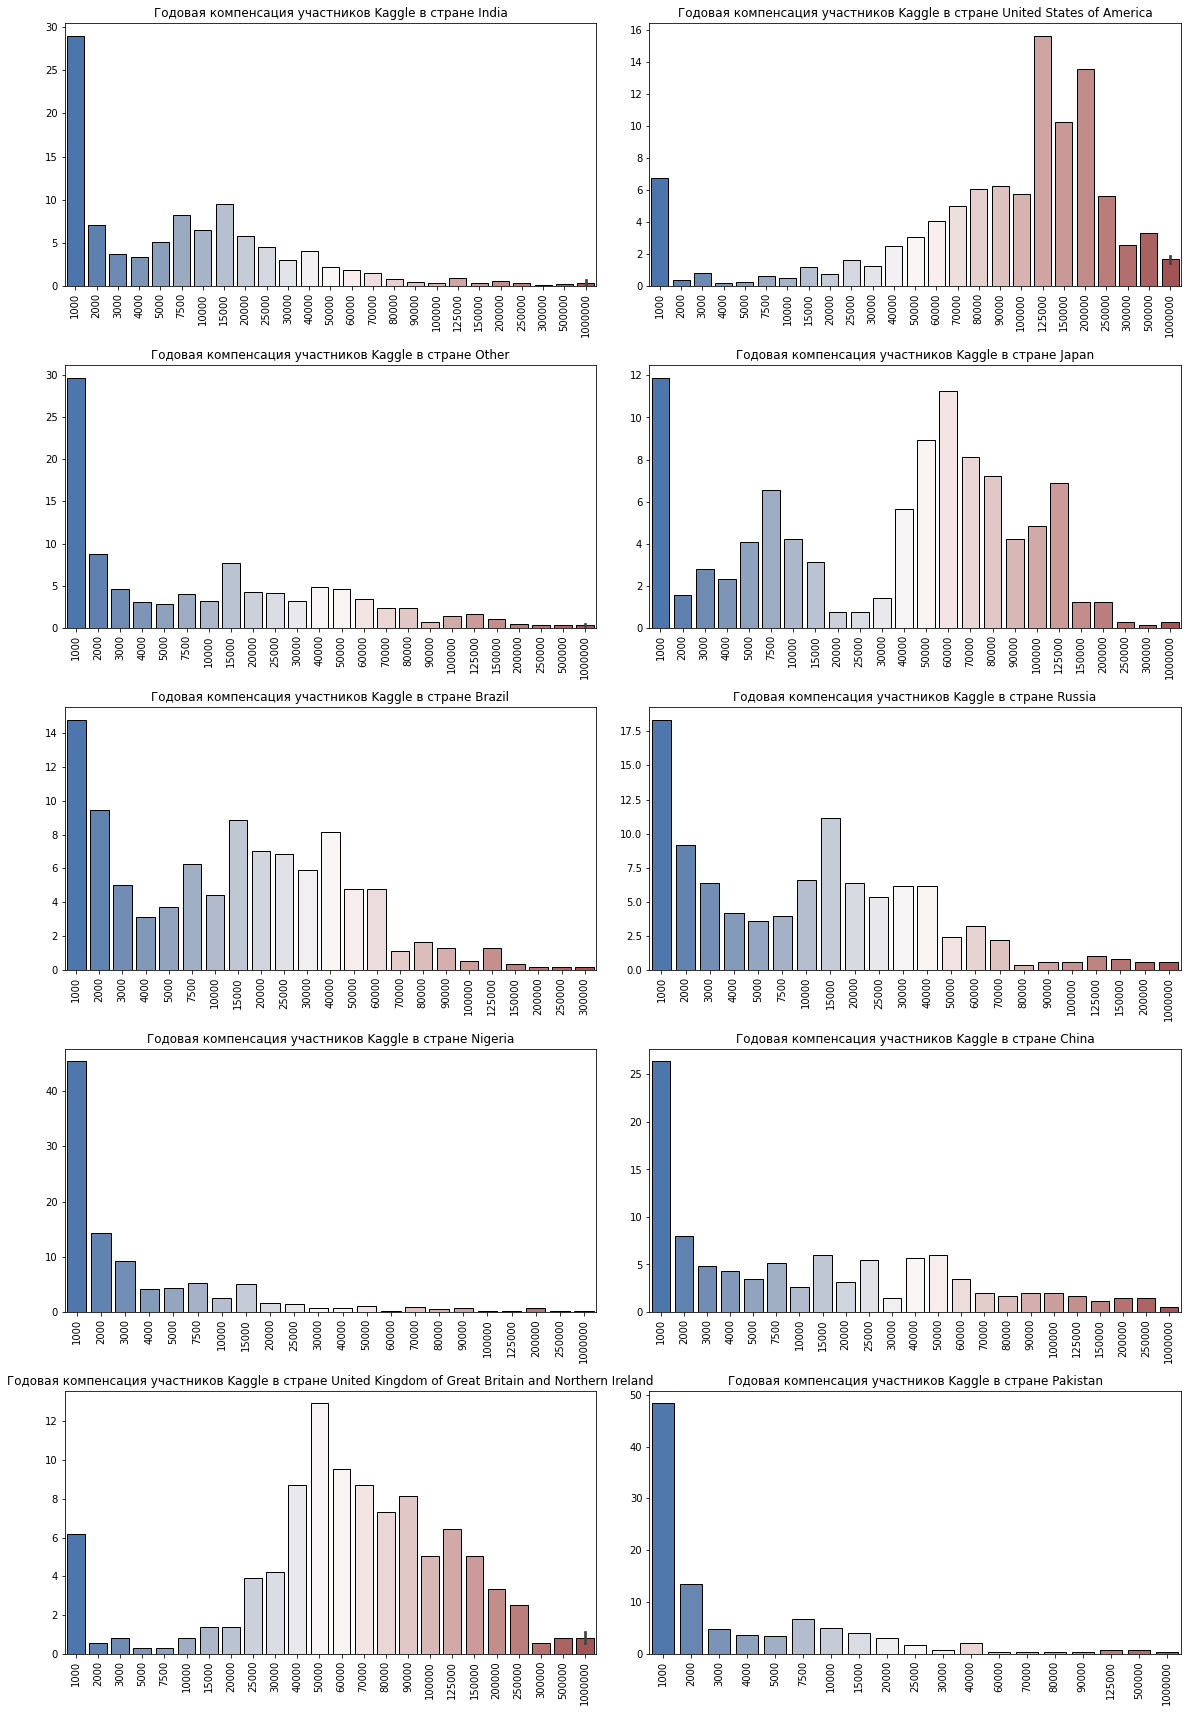

In [98]:
plt.figure(figsize=(20, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for n,c in enumerate(answers_country[:10].index, start=1):
    plt.subplot(5,2,n)
    show_compensation_in_country(c)

Примечание: если на оси написано например 5000, то это значит, что значение находится в промежутке от 4000 до 5000 и т.д. 

По всей видимости, yearly compensation это означает годовая зарплата. Если допустить, что это так, то можно заметить, то значения сильно различаются в зависимости от страны. Очень большая доля опрошенных имеет компенсацию менее 1000 долларов. Что это может значить? Для годовой зарплаты это слишком мало. Может быть это подработка? Или же часть респондентов на самом деле безработные, но при этом причисляют себя к определенной специализации? Возможно, это их хобби.

In [55]:
compensation_titles = df.groupby(['Q5', 'Q25'], as_index=False).size()
compensation_titles['Q25'] = compensation_titles['Q25'].apply(lambda x: int(re.sub(',', '', x.partition('-')[2]))+1 if '-' in x else 1000000)
compensation_titles

,Q5,Q25,size
0,Business Analyst,1000,147
1,Business Analyst,2000,59
2,Business Analyst,15000,61
3,Business Analyst,125000,37
4,Business Analyst,150000,18
...,...,...,...
322,Statistician,10000,12
323,Statistician,80000,5
324,Statistician,90000,4
325,Statistician,100000,3


In [100]:
def show_compensation_by_title(title):
    data=compensation_titles[compensation_titles['Q5']==title]
    sns.barplot(data=data, x='Q25', y='size', ec='k', palette='viridis',
              estimator=lambda x: sum(x)*100/data['size'].sum())
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Годовая компенсация участников Kaggle по профессии {title}');

In [105]:
titles = list(compensation_titles['Q5'].unique())
titles

['Business Analyst',
 'DBA/Database Engineer',
 'Data Analyst',
 'Data Engineer',
 'Data Scientist',
 'Developer Relations/Advocacy',
 'Machine Learning Engineer',
 'Other',
 'Product Manager',
 'Program/Project Manager',
 'Research Scientist',
 'Software Engineer',
 'Statistician']

In [112]:
set(df['Q5'].unique())-set(titles)

{'Currently not employed', 'Student'}

In [109]:
df[df['Q5']=='Currently not employed']['Q25'].unique()

array([nan], dtype=object)

In [113]:
df[df['Q5']=='Student']['Q25'].unique()

array([nan], dtype=object)

Стоит заметить, что категории Currently not employed и Research Scientist (временно безработный и исследователь) не попали в сгруппированный датафрейм по зарплатам. Они там просто не указаны.

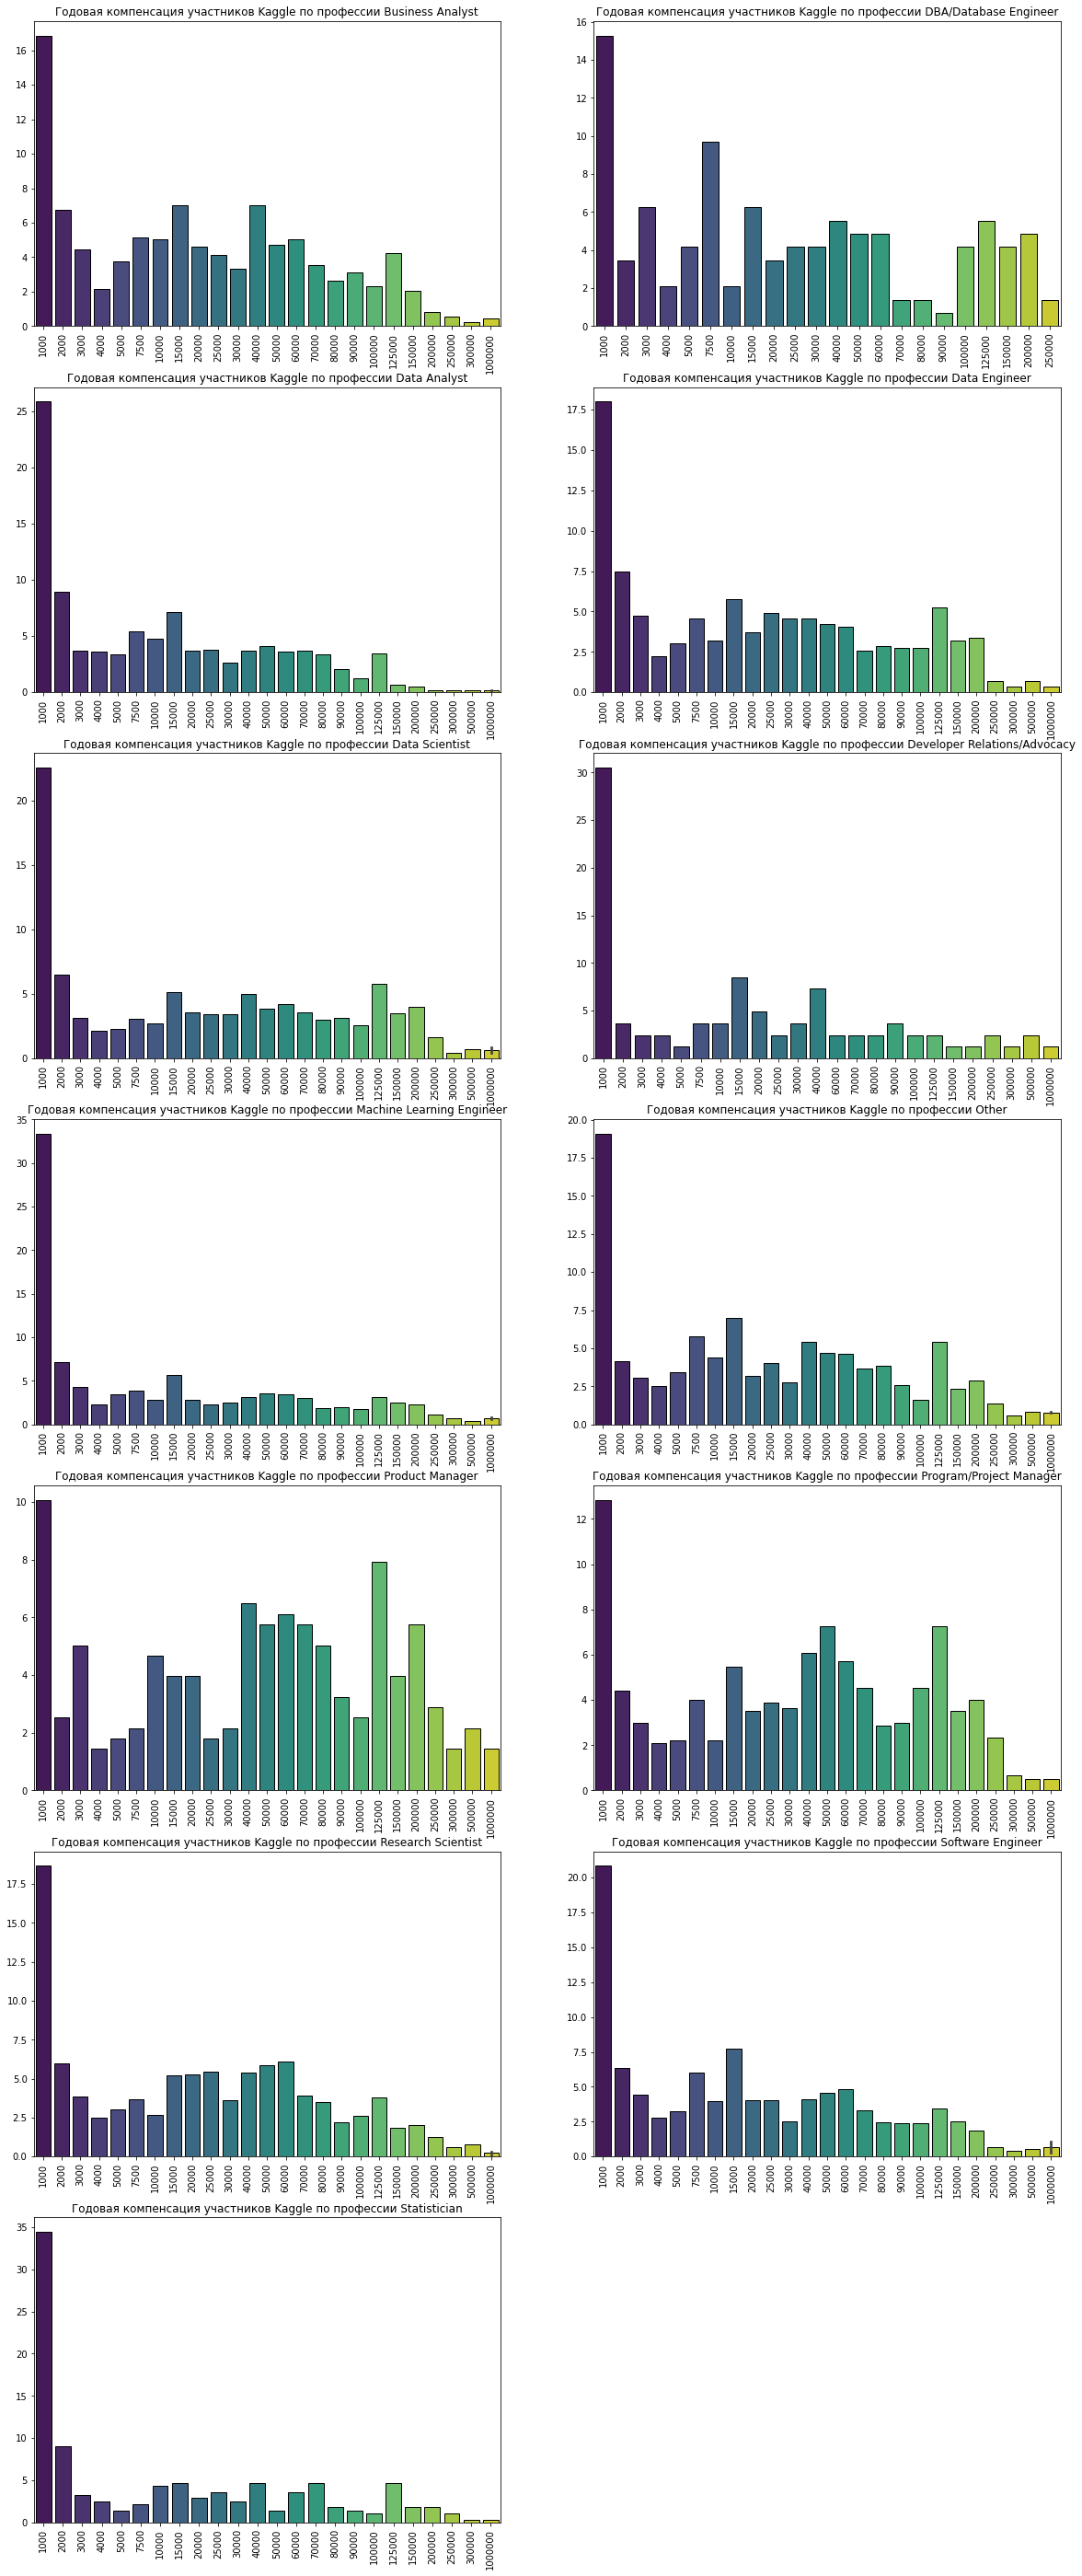

In [102]:
plt.figure(figsize=(20,50))
for n,t in enumerate(titles, start=1):
    plt.subplot(7,2,n)
    plt.title(f'Годовая компенсация для должности {t}')
    show_compensation_by_title(t)

Чисто визуально графики похожи, распределение примерно одинаковое у всех специализаций. Снова заметно, что много людей получают за свою деятельность менее 1000 долларов. Учитывая, что для безработных есть особая категория, то мне не совсем понятно, почему так происходит. Возможно и правда подработка. Не исключено, что часть опрошенных врет.

## Затраты на МО и облачные вычисления

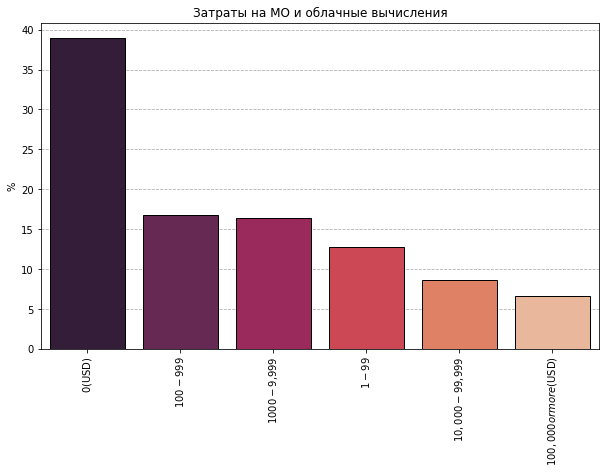

In [114]:
make_barplot('Q26', 'rocket', 'v', 'Затраты на МО и облачные вычисления')

Примерно половина опрошенных на машинное обучение и облачные вычисления потратила менее 100 долларов за последние 5 лет (примерно 38% из них не потратила ни копейки). Серьезно в это дело вкладываются около 15% (более 10000 долларов).

## Основной инструмент для анализа данных

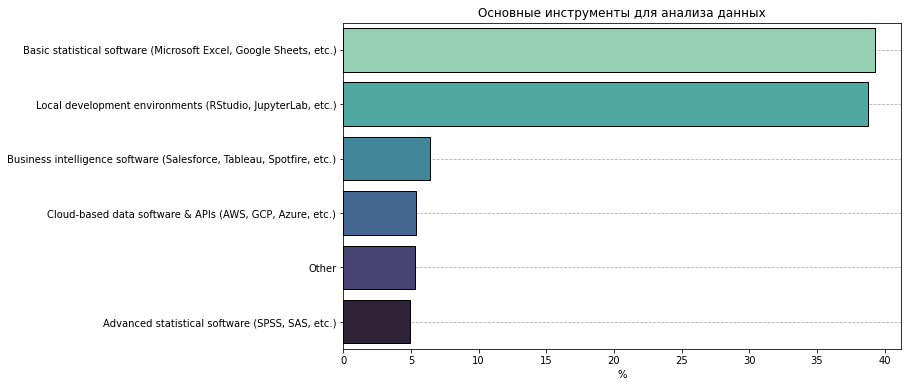

In [117]:
make_barplot('Q41', 'mako_r', 'h', 'Основные инструменты для анализа данных')

Наиболее часто пользователи Kaggle используют базовые инструменты наподобие Excel, примерно столько же людей использует среды типа RStudio и JupyterLab. С более специфическими средами работает намного меньше опрошенных.